# 00016577 ML Coursework

1 . Imports

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    mean_squared_error,
    mean_absolute_error,
    r2_score
)

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from xgboost import XGBClassifier, XGBRegressor

sns.set(style="whitegrid")
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")


2 . Data Loading

In [124]:
# 2. Load raw data
card_app = pd.read_csv("C:/Users/admin/Desktop/ML/Data/Card_application.csv")
card_credit = pd.read_csv("C:/Users/admin/Desktop/ML/Data/Card_credit.csv")




In [125]:
card_app.shape, card_credit.shape
print("Card_application:", card_app.shape)
print("Card_credit:", card_credit.shape)

display(card_app.head())
display(card_credit.head())

Card_application: (438557, 18)
Card_credit: (1048575, 3)


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,"427,500.00",Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.00
1,5008805,M,Y,Y,0,"427,500.00",Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.00
2,5008806,M,Y,Y,0,"112,500.00",Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.00
3,5008808,F,N,Y,0,"270,000.00",Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.00
4,5008809,F,N,Y,0,"270,000.00",Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.00


,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


3 . Merge two Data sets

3.1 Group by and aggregations

In [126]:
# Mark statuses (bad / late )
card_credit["bad"] = card_credit["STATUS"].isin(["2", "3", "4", "5"]).astype(int)
card_credit["late"] = card_credit["STATUS"].isin(["1"]).astype(int)

credit_agg = (
    card_credit
    .groupby("ID")
    .agg(
        max_bad=("bad", "max"),                 # target for classification
        any_late=("late", "max"),
        months_on_book=("MONTHS_BALANCE", "nunique"),
        min_month=("MONTHS_BALANCE", "min"),
        max_month=("MONTHS_BALANCE", "max")
    )
    .reset_index()
)

print("Aggregated data:", credit_agg.shape)
credit_agg.head()


Aggregated data: (45985, 6)


,ID,max_bad,any_late,months_on_book,min_month,max_month
0,5001711,0,0,4,-3,0
1,5001712,0,0,19,-18,0
2,5001713,0,0,22,-21,0
3,5001714,0,0,15,-14,0
4,5001715,0,0,60,-59,0


3.2 Merging with application data

In [127]:
data = card_app.merge(credit_agg, on="ID", how="inner")
print("Merged data shape:", data.shape)
data.head()



Merged data shape: (36457, 23)


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,max_bad,any_late,months_on_book,min_month,max_month
0,5008804,M,Y,Y,0,"427,500.00",Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.00,0,1,16,-15,0
1,5008805,M,Y,Y,0,"427,500.00",Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.00,0,1,15,-14,0
2,5008806,M,Y,Y,0,"112,500.00",Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.00,0,0,30,-29,0
3,5008808,F,N,Y,0,"270,000.00",Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.00,0,0,5,-4,0
4,5008809,F,N,Y,0,"270,000.00",Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.00,0,0,5,-26,-22


3.3 Applying business logic and creating target risk_score

In [128]:
data["risk_score"] = (
    1.0 * data["any_late"] +
    2.0 * data["max_bad"] +
    0.02 * data["months_on_book"]
)

data[["ID", "any_late", "max_bad", "months_on_book", "risk_score"]].head()


,ID,any_late,max_bad,months_on_book,risk_score
0,5008804,1,0,16,1.32
1,5008805,1,0,15,1.30
2,5008806,0,0,30,0.60
3,5008808,0,0,5,0.10
4,5008809,0,0,5,0.10


4 EDA (Data Analysis and Vizulaization)

In [129]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  object 
 2   FLAG_OWN_CAR         36457 non-null  object 
 3   FLAG_OWN_REALTY      36457 non-null  object 
 4   CNT_CHILDREN         36457 non-null  int64  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  object 
 7   NAME_EDUCATION_TYPE  36457 non-null  object 
 8   NAME_FAMILY_STATUS   36457 non-null  object 
 9   NAME_HOUSING_TYPE    36457 non-null  object 
 10  DAYS_BIRTH           36457 non-null  int64  
 11  DAYS_EMPLOYED        36457 non-null  int64  
 12  FLAG_MOBIL           36457 non-null  int64  
 13  FLAG_WORK_PHONE      36457 non-null  int64  
 14  FLAG_PHONE           36457 non-null  int64  
 15  FLAG_EMAIL           36457 non-null 

In [130]:
# Missing values
data.isna().sum().sort_values(ascending=False)


OCCUPATION_TYPE        11323
ID                         0
CODE_GENDER                0
max_month                  0
min_month                  0
months_on_book             0
any_late                   0
max_bad                    0
CNT_FAM_MEMBERS            0
FLAG_EMAIL                 0
FLAG_PHONE                 0
FLAG_WORK_PHONE            0
FLAG_MOBIL                 0
DAYS_EMPLOYED              0
DAYS_BIRTH                 0
NAME_HOUSING_TYPE          0
NAME_FAMILY_STATUS         0
NAME_EDUCATION_TYPE        0
NAME_INCOME_TYPE           0
AMT_INCOME_TOTAL           0
CNT_CHILDREN               0
FLAG_OWN_REALTY            0
FLAG_OWN_CAR               0
risk_score                 0
dtype: int64

In [131]:
# Numeric summary
data.describe()


,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,max_bad,any_late,months_on_book,min_month,max_month,risk_score
count,"36,457.00","36,457.00","36,457.00","36,457.00","36,457.00","36,457.00","36,457.00","36,457.00","36,457.00","36,457.00","36,457.00","36,457.00","36,457.00","36,457.00","36,457.00","36,457.00"
mean,"5,078,227.00",0.43,"186,685.74","-15,975.17","59,262.94",1.00,0.23,0.29,0.09,2.20,0.02,0.11,21.33,-26.16,-5.83,0.57
std,"41,875.24",0.74,"101,789.23","4,200.55","137,651.33",0.00,0.42,0.46,0.29,0.91,0.13,0.32,14.91,16.50,11.33,0.58
min,"5,008,804.00",0.00,"27,000.00","-25,152.00","-15,713.00",1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,-60.00,-60.00,0.02
25%,"5,042,028.00",0.00,"121,500.00","-19,438.00","-3,153.00",1.00,0.00,0.00,0.00,2.00,0.00,0.00,9.00,-39.00,-6.00,0.18
50%,"5,074,614.00",0.00,"157,500.00","-15,563.00","-1,552.00",1.00,0.00,0.00,0.00,2.00,0.00,0.00,18.00,-24.00,0.00,0.40
75%,"5,115,396.00",1.00,"225,000.00","-12,462.00",-408.00,1.00,0.00,1.00,0.00,3.00,0.00,0.00,31.00,-12.00,0.00,0.78
max,"5,150,487.00",19.00,"1,575,000.00","-7,489.00","365,243.00",1.00,1.00,1.00,1.00,20.00,1.00,1.00,61.00,0.00,0.00,4.22


0    35841
1      616
Name: max_bad, dtype: int64
0   98.31
1    1.69
Name: max_bad, dtype: float64


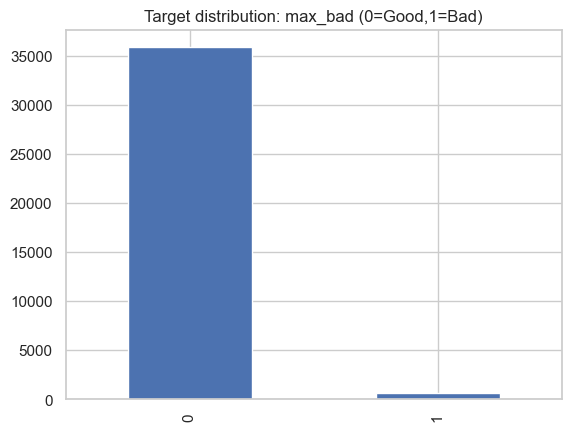

In [132]:
# Classification target distribution
print(data["max_bad"].value_counts())
print((data["max_bad"].value_counts(normalize=True) * 100).round(2))

data["max_bad"].value_counts().plot(kind="bar", title="Target distribution: max_bad (0=Good,1=Bad)")
plt.show()


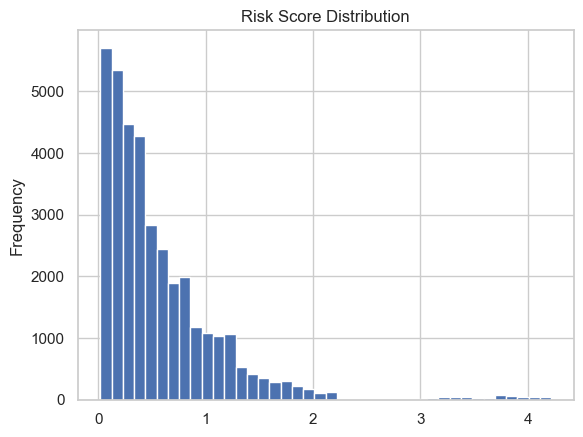

In [133]:
# Regression target summary
data["risk_score"].describe()
data["risk_score"].plot(kind="hist", bins=40, title="Risk Score Distribution")
plt.show()


In [134]:
### EDA continued

5 . Advanced EDA and Reports

5.1 Numeric distributions

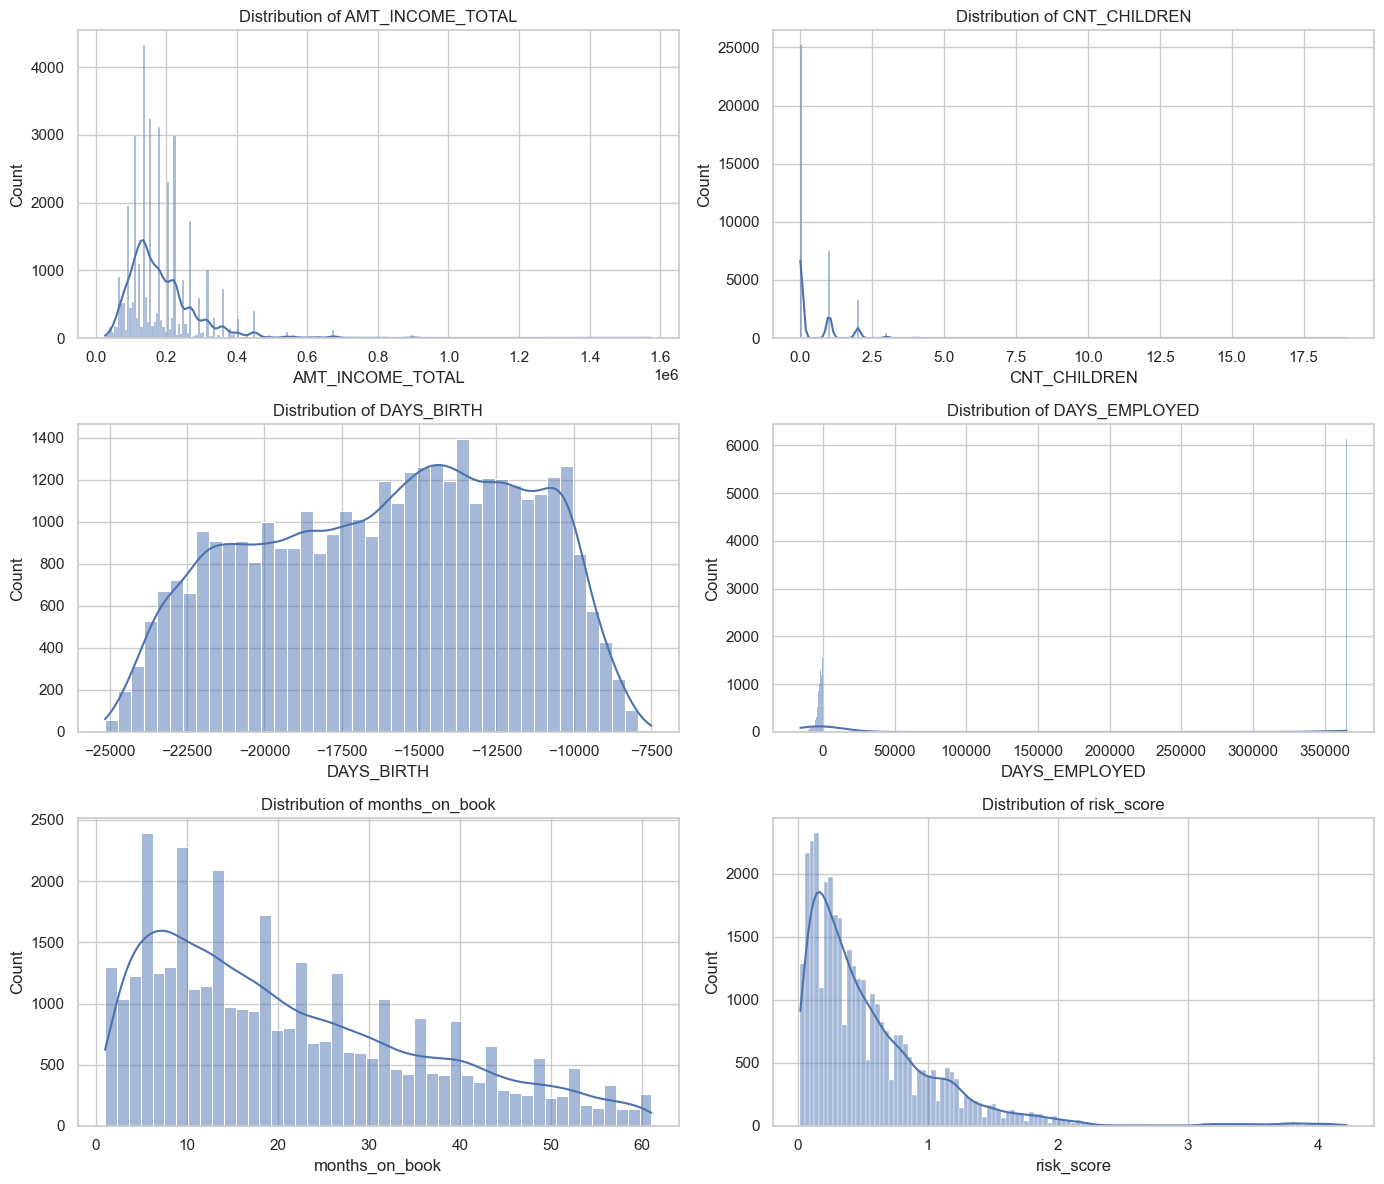

In [135]:
num_cols = [
    "AMT_INCOME_TOTAL",
    "CNT_CHILDREN",
    "DAYS_BIRTH",
    "DAYS_EMPLOYED",
    "months_on_book",
    "risk_score"
]

plt.figure(figsize=(14, 12))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data[col], kde=True)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()


<Axes: title={'center': 'Risk Score Distribution'}, ylabel='Frequency'>

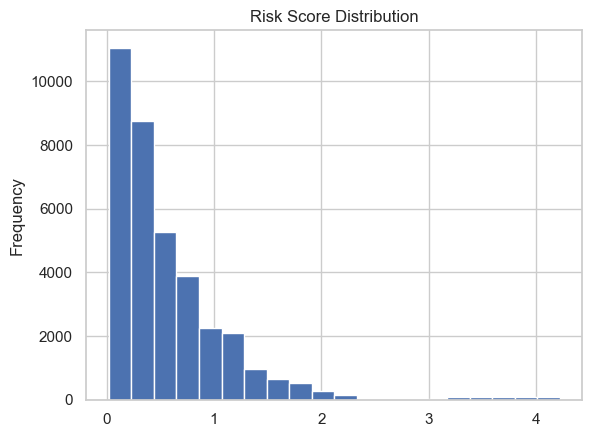

In [136]:
data["risk_score"].describe()
data["risk_score"].plot(kind="hist", bins=20, title="Risk Score Distribution")

5.2 Outliers

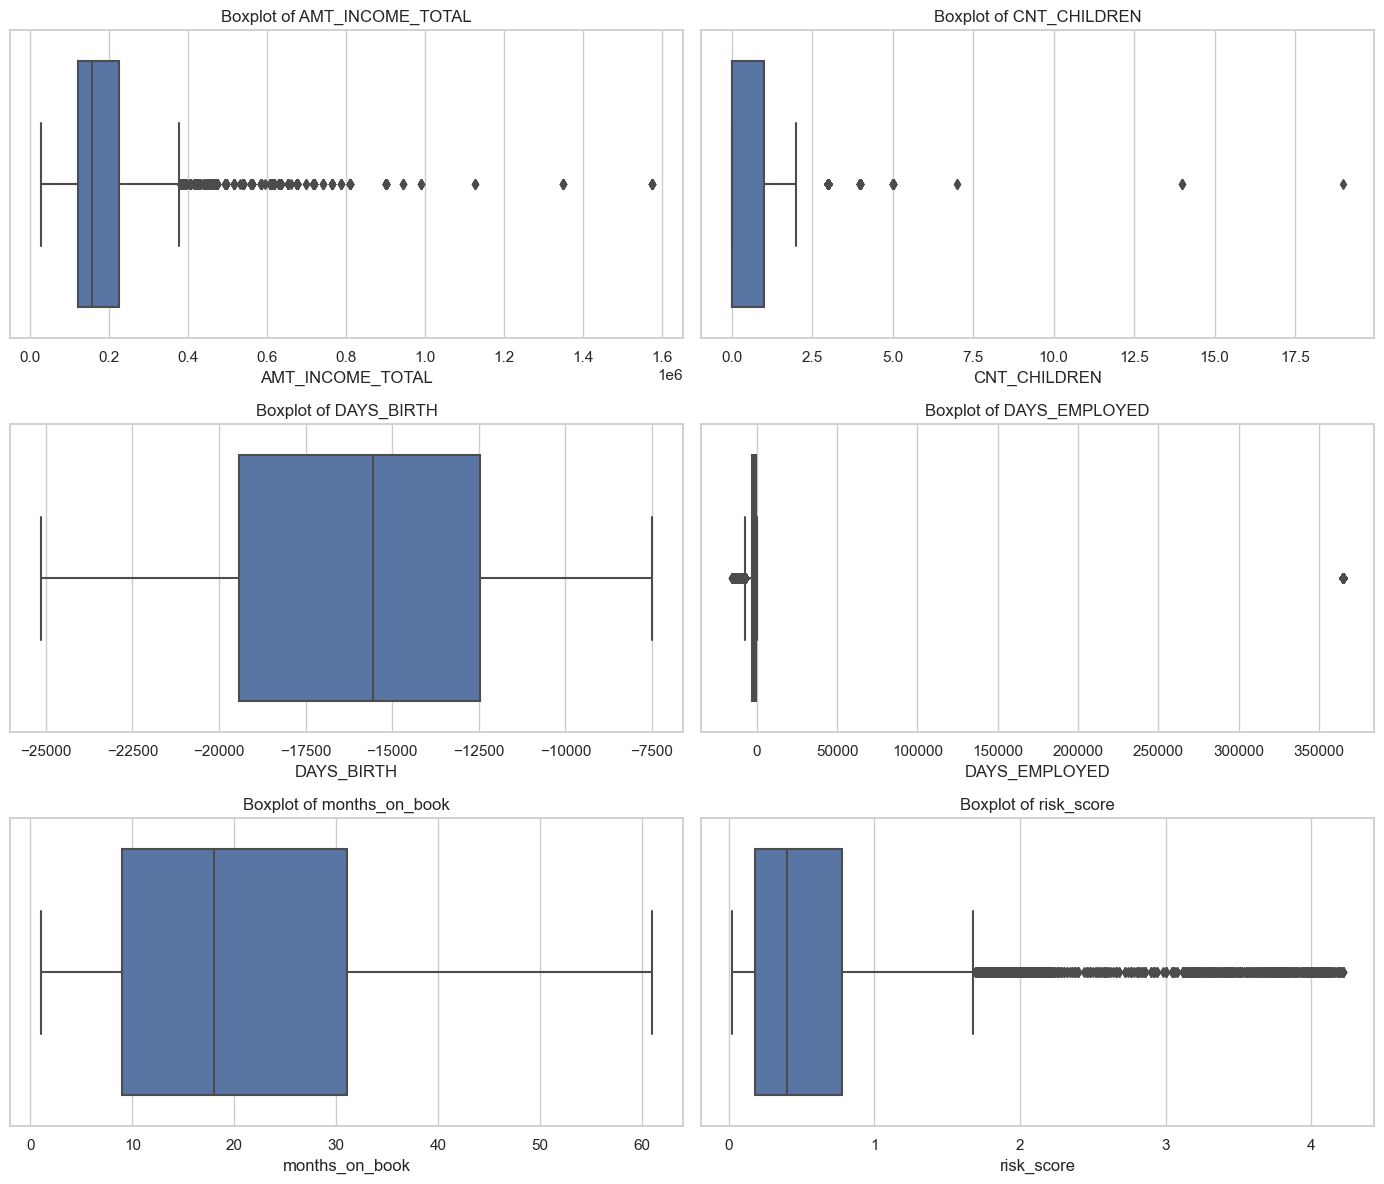

In [137]:
plt.figure(figsize=(14, 12))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x=data[col])
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()


5.3 Heatmap

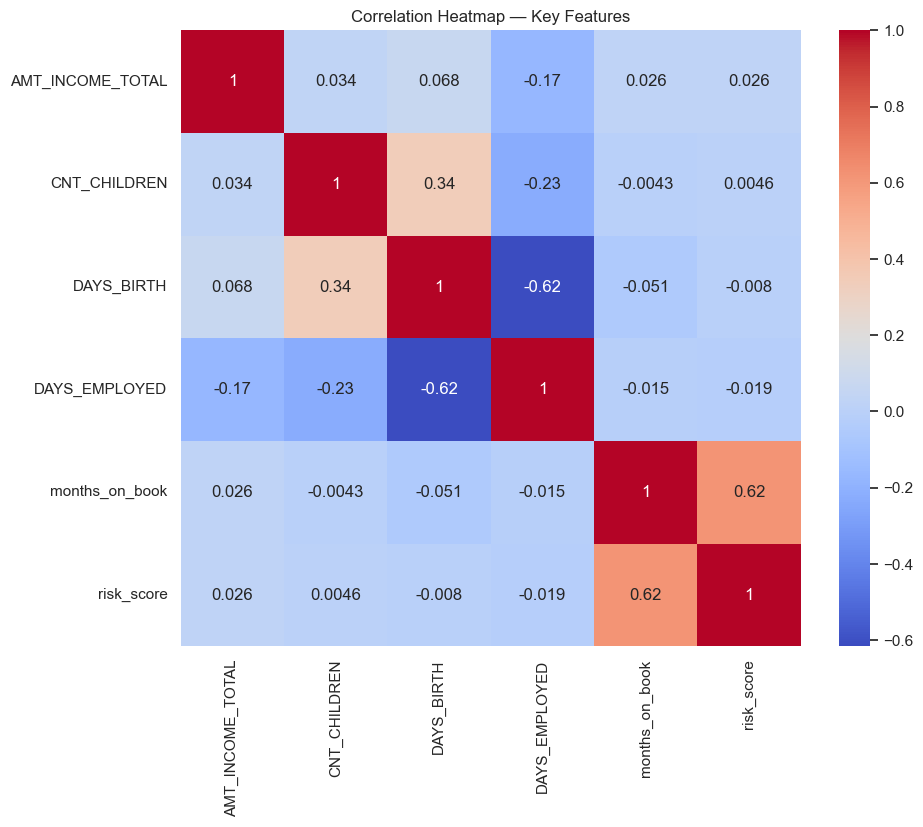

In [138]:
plt.figure(figsize=(10, 8))
sns.heatmap(data[num_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap — Key Features")
plt.show()


C:\Users\admin\AppData\Local\Temp\ipykernel_2800\3822840175.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), cmap="coolwarm", annot=False)


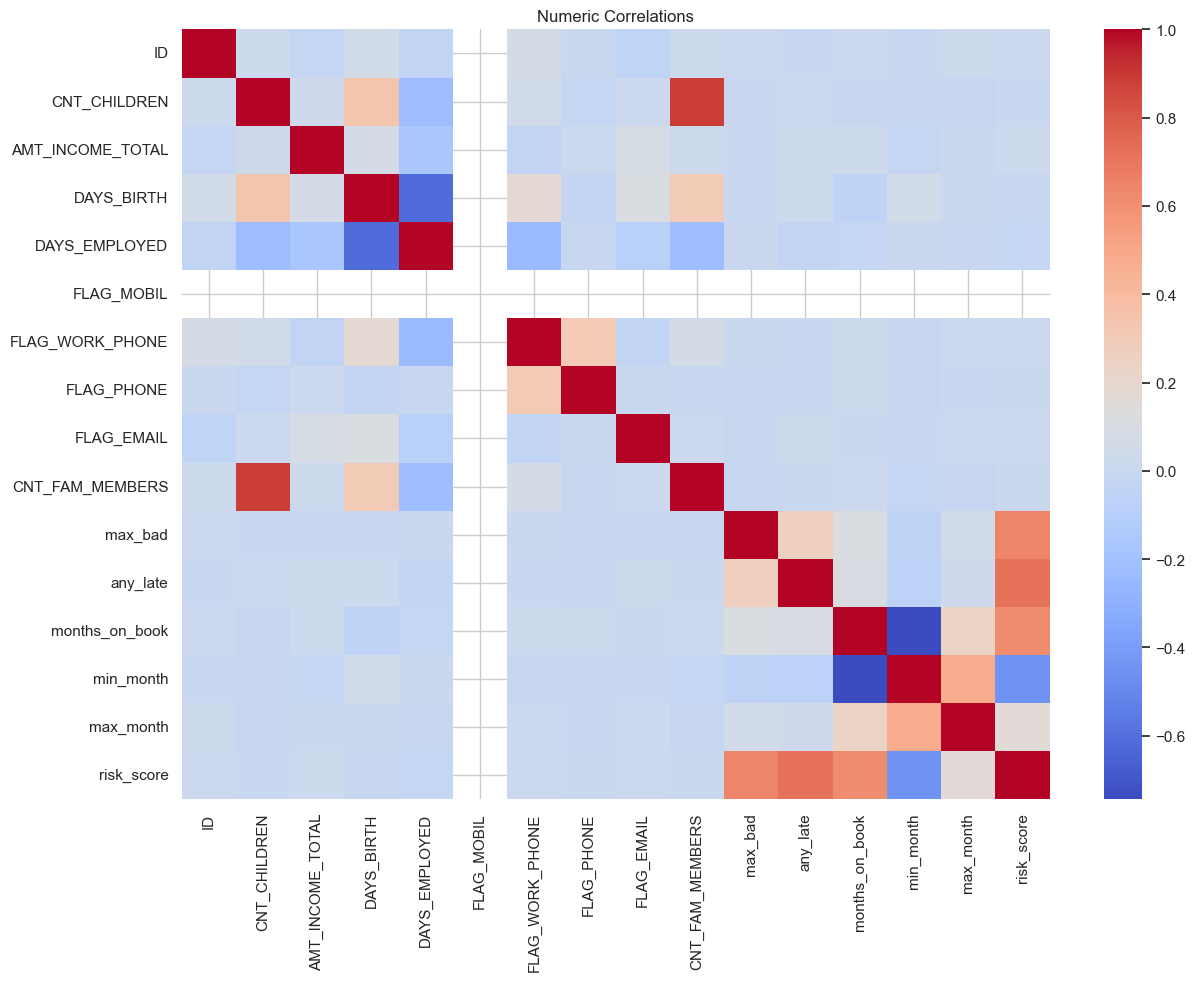

In [139]:
plt.figure(figsize=(14,10))
sns.heatmap(data.corr(), cmap="coolwarm", annot=False)
plt.title("Numeric Correlations")
plt.show()

5.4 Categorical Distributions

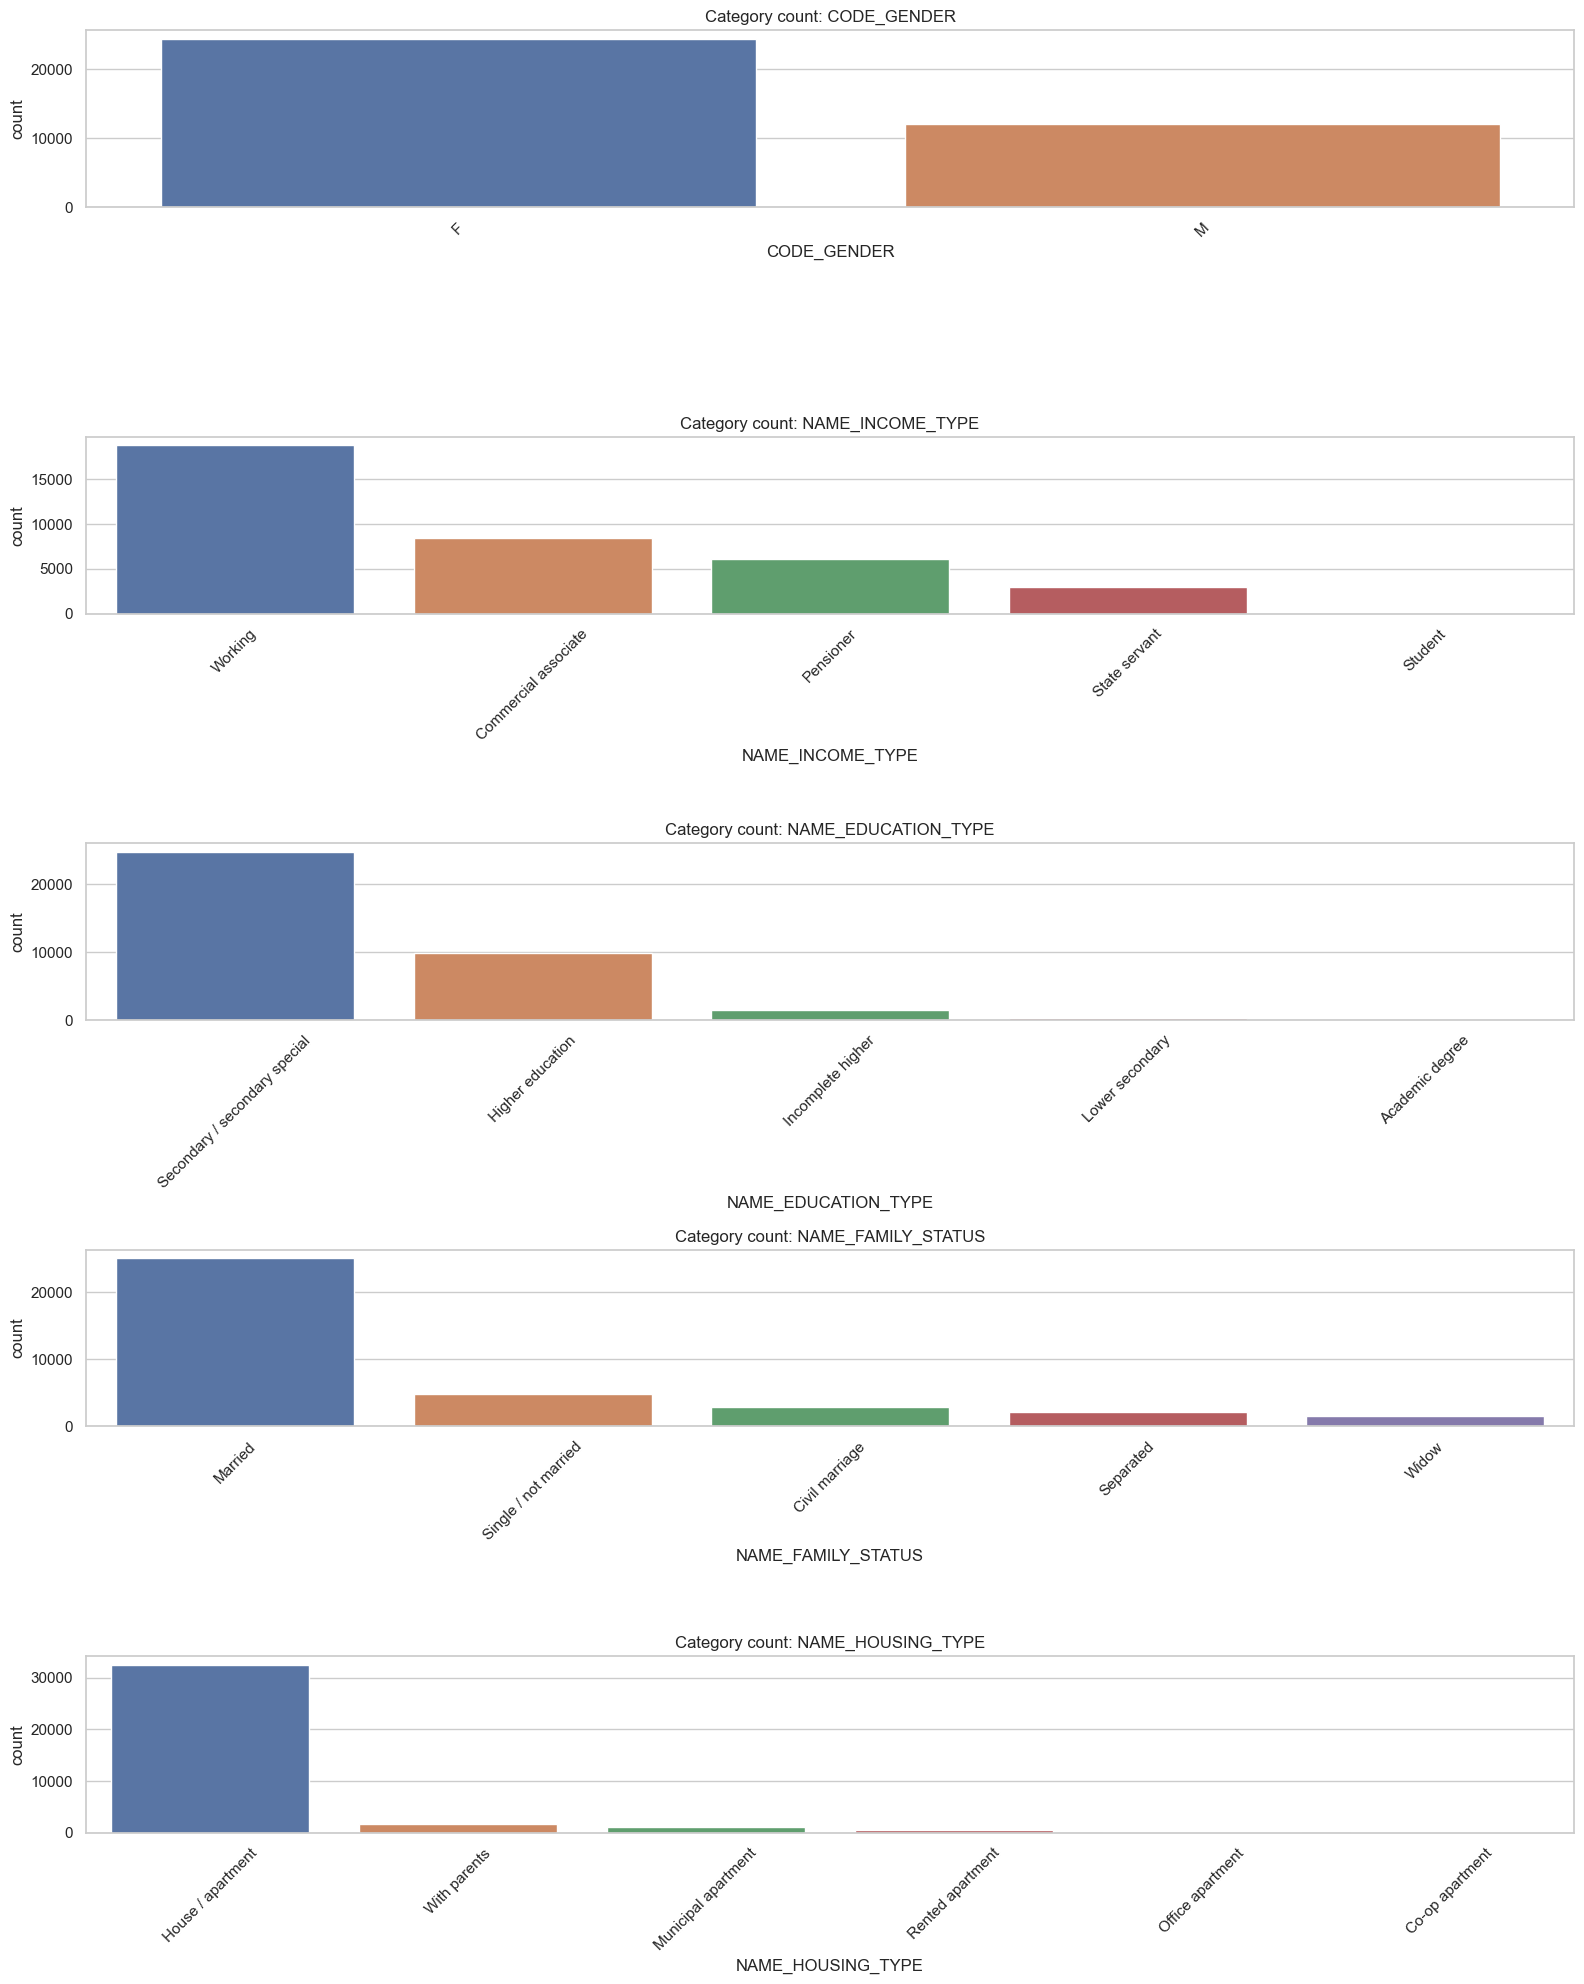

In [140]:
cat_cols_eda = [
    "CODE_GENDER",
    "NAME_INCOME_TYPE",
    "NAME_EDUCATION_TYPE",
    "NAME_FAMILY_STATUS",
    "NAME_HOUSING_TYPE"
]

plt.figure(figsize=(16, 20))
for i, col in enumerate(cat_cols_eda, 1):
    plt.subplot(len(cat_cols_eda), 1, i)
    sns.countplot(data=data, x=col, order=data[col].value_counts().index)
    plt.xticks(rotation=45)
    plt.title(f"Category count: {col}")
plt.tight_layout()
plt.show()


5.5 Numeric values and Target 

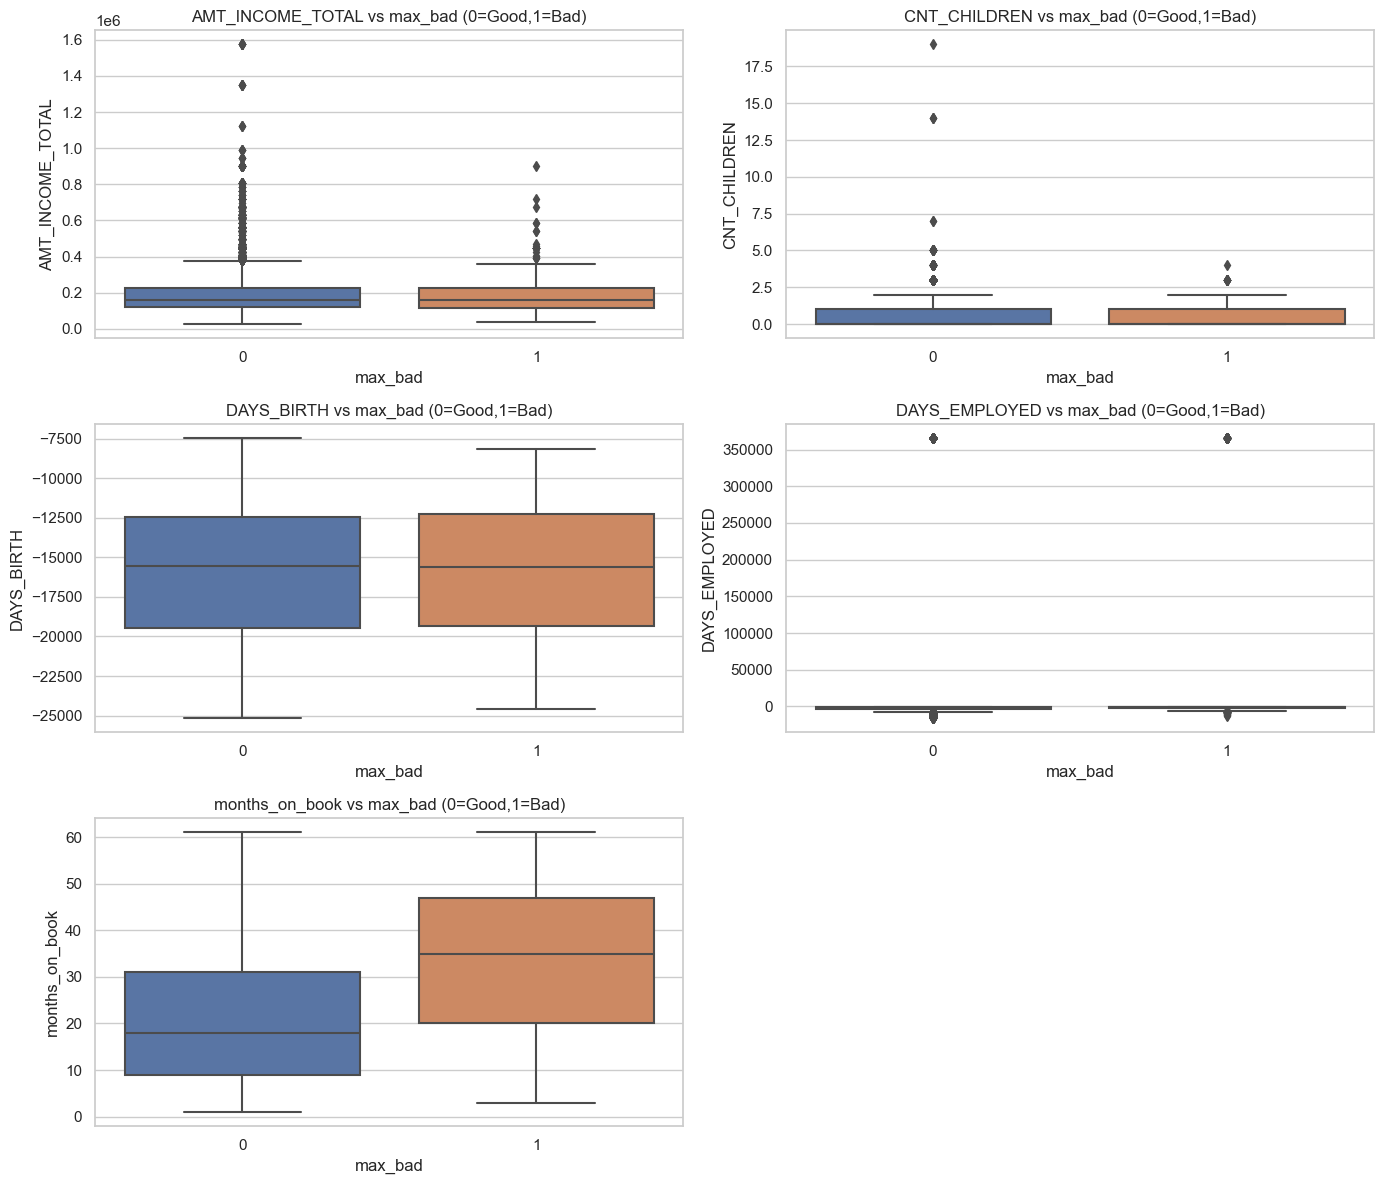

In [141]:
plt.figure(figsize=(14, 12))
for i, col in enumerate(num_cols[:-1], 1):  # skip risk_score
    plt.subplot(3, 2, i)
    sns.boxplot(x=data["max_bad"], y=data[col])
    plt.title(f"{col} vs max_bad (0=Good,1=Bad)")
plt.tight_layout()
plt.show()


5.6 Reports and Pivots

In [142]:
pivot_income_family = pd.pivot_table(
    data,
    values="AMT_INCOME_TOTAL",
    index="NAME_INCOME_TYPE",
    columns="NAME_FAMILY_STATUS",
    aggfunc="mean"
).round(0)

pivot_income_family


NAME_FAMILY_STATUS,Civil marriage,Married,Separated,Single / not married,Widow
NAME_INCOME_TYPE,,,,,
Commercial associate,"205,185.00","217,626.00","230,361.00","226,657.00","191,545.00"
Pensioner,"164,169.00","145,766.00","148,117.00","158,138.00","149,484.00"
State servant,"180,234.00","207,041.00","189,806.00","200,340.00","222,015.00"
Student,"112,500.00","171,000.00",NaN,"135,000.00",NaN
Working,"174,594.00","182,378.00","189,318.00","182,690.00","181,882.00"


In [143]:
pivot_education_employment = pd.pivot_table(
    data,
    values="DAYS_EMPLOYED",
    index="NAME_EDUCATION_TYPE",
    aggfunc=["mean", "median", "count"]
).round(0)

pivot_education_employment


,mean,median,count
,DAYS_EMPLOYED,DAYS_EMPLOYED,DAYS_EMPLOYED
NAME_EDUCATION_TYPE,,,
Academic degree,"9,494.00",-979,32
Higher education,"34,959.00",-1682,9864
Incomplete higher,"12,965.00",-1653,1410
Lower secondary,"155,023.00",-486,374
Secondary / secondary special,"70,192.00",-1472,24777


6 . Data Cleaning and Preprocessing

In [144]:
# Identify categorical columns from dtypes
categorical_cols = data.select_dtypes(include=["object"]).columns.tolist()

# Identify numeric columns (exclude targets)
numeric_cols = data.select_dtypes(include=["int64", "float64"]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in ["max_bad", "risk_score"]]

categorical_cols, numeric_cols


(['CODE_GENDER',
  'FLAG_OWN_CAR',
  'FLAG_OWN_REALTY',
  'NAME_INCOME_TYPE',
  'NAME_EDUCATION_TYPE',
  'NAME_FAMILY_STATUS',
  'NAME_HOUSING_TYPE',
  'OCCUPATION_TYPE'],
 ['ID',
  'CNT_CHILDREN',
  'AMT_INCOME_TOTAL',
  'DAYS_BIRTH',
  'DAYS_EMPLOYED',
  'FLAG_MOBIL',
  'FLAG_WORK_PHONE',
  'FLAG_PHONE',
  'FLAG_EMAIL',
  'CNT_FAM_MEMBERS',
  'months_on_book',
  'min_month',
  'max_month'])

In [145]:
#Missing data work

In [146]:
# Fill numeric with median
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].median())

# Fill categorical with "Unknown"
data[categorical_cols] = data[categorical_cols].fillna("Unknown")

# Check
data.isna().sum().sum()


0

6.1 Encoding

In [147]:
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)
data_encoded.shape


(36457, 54)

6.2 Test and Train splitting

In [148]:
X = data_encoded.drop(columns=["max_bad", "risk_score"])
y_class = data_encoded["max_bad"]
y_reg = data_encoded["risk_score"]

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X, y_class, test_size=0.2, random_state=42, stratify=y_class
)

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

X_train_c.shape, X_train_r.shape


((29165, 52), (29165, 52))

6.3 Scaling

In [149]:
scaler_c = StandardScaler()
X_train_c_scaled = scaler_c.fit_transform(X_train_c)
X_test_c_scaled = scaler_c.transform(X_test_c)

scaler_r = StandardScaler()
X_train_r_scaled = scaler_r.fit_transform(X_train_r)
X_test_r_scaled = scaler_r.transform(X_test_r)


# 7 . Modeling (Base)

7 A classification (baseline)

In [150]:
#Logistic Regression

In [151]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(3,2))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Predicted Good', 'Predicted Bad'],
                yticklabels=['Actual Good', 'Actual Bad'])
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


In [152]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
log_clf = LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1)
log_clf.fit(X_train_c_scaled, y_train_c)

y_pred_log = log_clf.predict(X_test_c_scaled)
y_proba_log = log_clf.predict_proba(X_test_c_scaled)[:, 1]

print("=== Logistic Regression (Baseline) ===")
print(classification_report(y_test_c, y_pred_log))
print("ROC-AUC:", roc_auc_score(y_test_c, y_proba_log))



=== Logistic Regression (Baseline) ===
              precision    recall  f1-score   support

           0       0.99      0.88      0.93      7169
           1       0.09      0.72      0.16       123

    accuracy                           0.88      7292
   macro avg       0.54      0.80      0.55      7292
weighted avg       0.98      0.88      0.92      7292

ROC-AUC: 0.869945916644269


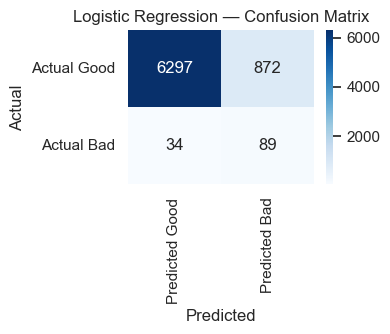

In [153]:
plot_confusion(y_test_c, y_pred_log, "Logistic Regression — Confusion Matrix")


In [154]:
# Random Forest Classifier (baseline)

In [155]:
rf_clf_base = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_clf_base.fit(X_train_c, y_train_c)

y_pred_rf_base = rf_clf_base.predict(X_test_c)
y_proba_rf_base = rf_clf_base.predict_proba(X_test_c)[:, 1]

print("=== Random Forest Classifier (Baseline) ===")
print(classification_report(y_test_c, y_pred_rf_base))
print("ROC-AUC:", roc_auc_score(y_test_c, y_proba_rf_base))


=== Random Forest Classifier (Baseline) ===
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      7169
           1       0.17      0.58      0.26       123

    accuracy                           0.94      7292
   macro avg       0.58      0.76      0.62      7292
weighted avg       0.98      0.94      0.96      7292

ROC-AUC: 0.9031205948828911


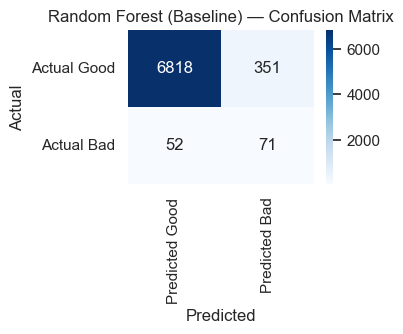

In [156]:
plot_confusion(y_test_c, y_pred_rf_base, "Random Forest (Baseline) — Confusion Matrix")


In [157]:
# XG boost Classifier (baseline)

In [158]:
scale_pos = y_train_c.value_counts()[0] / y_train_c.value_counts()[1]

xgb_clf_base = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    scale_pos_weight=scale_pos,
    n_jobs=-1
)

xgb_clf_base.fit(X_train_c, y_train_c)

y_pred_xgb_base = xgb_clf_base.predict(X_test_c)
y_proba_xgb_base = xgb_clf_base.predict_proba(X_test_c)[:, 1]

print("=== XGBoost Classifier (Baseline) ===")
print(classification_report(y_test_c, y_pred_xgb_base))
print("ROC-AUC:", roc_auc_score(y_test_c, y_proba_xgb_base))


=== XGBoost Classifier (Baseline) ===
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      7169
           1       0.18      0.69      0.29       123

    accuracy                           0.94      7292
   macro avg       0.59      0.82      0.63      7292
weighted avg       0.98      0.94      0.96      7292

ROC-AUC: 0.9077316857699195


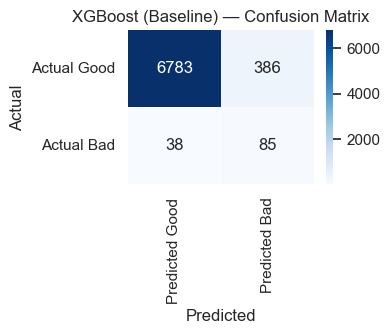

In [159]:
plot_confusion(y_test_c, y_pred_xgb_base, "XGBoost (Baseline) — Confusion Matrix")


In [160]:
# Classification Results table (baseline)

In [161]:
results_class_baseline = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest (base)", "XGBoost (base)"],
    "Accuracy": [
        accuracy_score(y_test_c, y_pred_log),
        accuracy_score(y_test_c, y_pred_rf_base),
        accuracy_score(y_test_c, y_pred_xgb_base)
    ],
    "Precision": [
        precision_score(y_test_c, y_pred_log, zero_division=0),
        precision_score(y_test_c, y_pred_rf_base, zero_division=0),
        precision_score(y_test_c, y_pred_xgb_base, zero_division=0)
    ],
    "Recall": [
        recall_score(y_test_c, y_pred_log),
        recall_score(y_test_c, y_pred_rf_base),
        recall_score(y_test_c, y_pred_xgb_base)
    ],
    "F1-Score": [
        f1_score(y_test_c, y_pred_log),
        f1_score(y_test_c, y_pred_rf_base),
        f1_score(y_test_c, y_pred_xgb_base)
    ],
    "ROC-AUC": [
        roc_auc_score(y_test_c, y_proba_log),
        roc_auc_score(y_test_c, y_proba_rf_base),
        roc_auc_score(y_test_c, y_proba_xgb_base)
    ]
})

results_class_baseline


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.88,0.09,0.72,0.16,0.87
1,Random Forest (base),0.94,0.17,0.58,0.26,0.90
2,XGBoost (base),0.94,0.18,0.69,0.29,0.91


7 B. Regression – Baseline Models 

In [162]:
# 7B.1 Linear Regression

In [163]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_r_scaled, y_train_r)

y_pred_lin = lin_reg.predict(X_test_r_scaled)

print("=== Linear Regression (Baseline) ===")
print("MSE:", mean_squared_error(y_test_r, y_pred_lin))
print("RMSE:", np.sqrt(mean_squared_error(y_test_r, y_pred_lin)))
print("MAE:", mean_absolute_error(y_test_r, y_pred_lin))
print("R²:", r2_score(y_test_r, y_pred_lin))


=== Linear Regression (Baseline) ===
MSE: 0.056419120837924
RMSE: 0.23752709495534188
MAE: 0.07053869803969515
R²: 0.8245839891031501


In [164]:
#7B.2 Random Forest Regressor (baseline)

In [165]:
rf_reg_base = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)

rf_reg_base.fit(X_train_r, y_train_r)
y_pred_rf_r_base = rf_reg_base.predict(X_test_r)

print("=== Random Forest Regressor (Baseline) ===")
print("MSE:", mean_squared_error(y_test_r, y_pred_rf_r_base))
print("RMSE:", np.sqrt(mean_squared_error(y_test_r, y_pred_rf_r_base)))
print("MAE:", mean_absolute_error(y_test_r, y_pred_rf_r_base))
print("R²:", r2_score(y_test_r, y_pred_rf_r_base))


=== Random Forest Regressor (Baseline) ===
MSE: 0.054247722713185745
RMSE: 0.23291140528790286
MAE: 0.053559292465705115
R²: 0.8313352108778512


In [166]:
#7B.3 XGBoost Regressor (baseline)

In [167]:
xgb_reg_base = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1
)

xgb_reg_base.fit(X_train_r, y_train_r)
y_pred_xgb_r_base = xgb_reg_base.predict(X_test_r)

print("=== XGBoost Regressor (Baseline) ===")
print("MSE:", mean_squared_error(y_test_r, y_pred_xgb_r_base))
print("RMSE:", np.sqrt(mean_squared_error(y_test_r, y_pred_xgb_r_base)))
print("MAE:", mean_absolute_error(y_test_r, y_pred_xgb_r_base))
print("R²:", r2_score(y_test_r, y_pred_xgb_r_base))


=== XGBoost Regressor (Baseline) ===
MSE: 0.05105212227889498
RMSE: 0.22594716700789808
MAE: 0.05752019950253322
R²: 0.8412708403644193


In [168]:
#Baseline Regressions Table 

In [169]:
results_reg_baseline = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest (base)", "XGBoost (base)"],
    "MSE": [
        mean_squared_error(y_test_r, y_pred_lin),
        mean_squared_error(y_test_r, y_pred_rf_r_base),
        mean_squared_error(y_test_r, y_pred_xgb_r_base)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test_r, y_pred_lin)),
        np.sqrt(mean_squared_error(y_test_r, y_pred_rf_r_base)),
        np.sqrt(mean_squared_error(y_test_r, y_pred_xgb_r_base))
    ],
    "MAE": [
        mean_absolute_error(y_test_r, y_pred_lin),
        mean_absolute_error(y_test_r, y_pred_rf_r_base),
        mean_absolute_error(y_test_r, y_pred_xgb_r_base)
    ],
    "R²": [
        r2_score(y_test_r, y_pred_lin),
        r2_score(y_test_r, y_pred_rf_r_base),
        r2_score(y_test_r, y_pred_xgb_r_base)
    ]
})

results_reg_baseline


,Model,MSE,RMSE,MAE,R²
0,Linear Regression,0.06,0.24,0.07,0.82
1,Random Forest (base),0.05,0.23,0.05,0.83
2,XGBoost (base),0.05,0.23,0.06,0.84


8 . Hyperparameter tuning

8.1 Random Forest Classifier tuning

In [170]:
param_grid_rf = {
    "n_estimators": [200, 300],
    "max_depth": [8, 12, 16],
    "min_samples_split": [2, 5]
}

grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(class_weight="balanced", random_state=42),
    param_grid=param_grid_rf,
    scoring="f1",
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train_c, y_train_c)

print("Best RF params:", grid_rf.best_params_)
best_rf_clf = grid_rf.best_estimator_


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best RF params: {'max_depth': 16, 'min_samples_split': 5, 'n_estimators': 200}


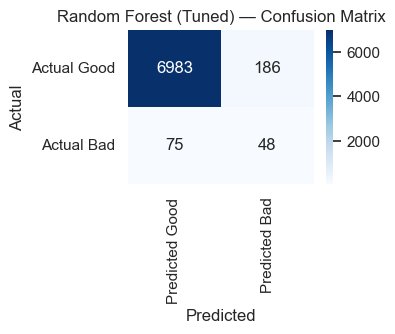

In [171]:
plot_confusion(y_test_c, y_pred_rf_tuned, "Random Forest (Tuned) — Confusion Matrix")


8.2 XGBoost Classifier tuning

In [172]:
param_grid_xgb = {
    "n_estimators": [200, 300],
    "max_depth": [4, 5, 6],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0]
}

grid_xgb = GridSearchCV(
    estimator=XGBClassifier(
        eval_metric="logloss",
        scale_pos_weight=scale_pos,
        n_jobs=-1
    ),
    param_grid=param_grid_xgb,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_xgb.fit(X_train_c, y_train_c)

print("Best XGB Classifier params:", grid_xgb.best_params_)
best_xgb_clf = grid_xgb.best_estimator_


Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best XGB Classifier params: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.7}


8.3 XGBoost Regressor tuning

In [173]:
param_grid_xgb_reg = {
    "n_estimators": [200, 300],
    "max_depth": [4, 5, 6],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0]
}

grid_xgb_reg = GridSearchCV(
    estimator=XGBRegressor(n_jobs=-1),
    param_grid=param_grid_xgb_reg,
    scoring="r2",
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_xgb_reg.fit(X_train_r, y_train_r)

print("Best XGB Regressor params:", grid_xgb_reg.best_params_)
best_xgb_reg = grid_xgb_reg.best_estimator_


Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best XGB Regressor params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}


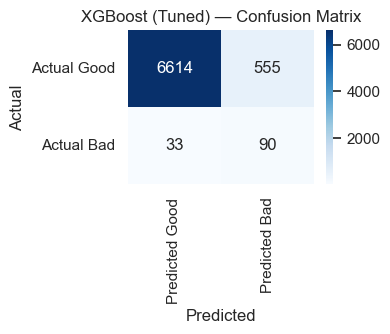

In [174]:
plot_confusion(y_test_c, y_pred_xgb_tuned, "XGBoost (Tuned) — Confusion Matrix")


9. Tuned Modeling

9.1 Tuned classification metrics

In [175]:
# RF tuned
y_pred_rf_tuned = best_rf_clf.predict(X_test_c)
y_proba_rf_tuned = best_rf_clf.predict_proba(X_test_c)[:, 1]

# XGB tuned
y_pred_xgb_tuned = best_xgb_clf.predict(X_test_c)
y_proba_xgb_tuned = best_xgb_clf.predict_proba(X_test_c)[:, 1]

results_class_tuned = pd.DataFrame({
    "Model": ["Random Forest (tuned)", "XGBoost (tuned)"],
    "Accuracy": [
        accuracy_score(y_test_c, y_pred_rf_tuned),
        accuracy_score(y_test_c, y_pred_xgb_tuned)
    ],
    "Precision": [
        precision_score(y_test_c, y_pred_rf_tuned, zero_division=0),
        precision_score(y_test_c, y_pred_xgb_tuned, zero_division=0)
    ],
    "Recall": [
        recall_score(y_test_c, y_pred_rf_tuned),
        recall_score(y_test_c, y_pred_xgb_tuned)
    ],
    "F1-Score": [
        f1_score(y_test_c, y_pred_rf_tuned),
        f1_score(y_test_c, y_pred_xgb_tuned)
    ],
    "ROC-AUC": [
        roc_auc_score(y_test_c, y_proba_rf_tuned),
        roc_auc_score(y_test_c, y_proba_xgb_tuned)
    ]
})

results_class_tuned


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Random Forest (tuned),0.96,0.21,0.39,0.27,0.90
1,XGBoost (tuned),0.92,0.14,0.73,0.23,0.90


9.2 Tuned regression metrics

In [176]:
y_pred_xgb_r_tuned = best_xgb_reg.predict(X_test_r)

results_reg_tuned = pd.DataFrame({
    "Model": ["XGBoost Regressor (tuned)"],
    "MSE": [mean_squared_error(y_test_r, y_pred_xgb_r_tuned)],
    "RMSE": [np.sqrt(mean_squared_error(y_test_r, y_pred_xgb_r_tuned))],
    "MAE": [mean_absolute_error(y_test_r, y_pred_xgb_r_tuned)],
    "R²": [r2_score(y_test_r, y_pred_xgb_r_tuned)]
})

results_reg_tuned


,Model,MSE,RMSE,MAE,R²
0,XGBoost Regressor (tuned),0.05,0.23,0.06,0.84


10 . Models Comparing

In [177]:
print("=== Classification: Baseline vs Tuned ===")
pd.concat([results_class_baseline, results_class_tuned], ignore_index=True)


=== Classification: Baseline vs Tuned ===


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.88,0.09,0.72,0.16,0.87
1,Random Forest (base),0.94,0.17,0.58,0.26,0.90
2,XGBoost (base),0.94,0.18,0.69,0.29,0.91
3,Random Forest (tuned),0.96,0.21,0.39,0.27,0.90
4,XGBoost (tuned),0.92,0.14,0.73,0.23,0.90


In [178]:
print("=== Regression: Baseline vs Tuned ===")
pd.concat([results_reg_baseline, results_reg_tuned], ignore_index=True)


=== Regression: Baseline vs Tuned ===


,Model,MSE,RMSE,MAE,R²
0,Linear Regression,0.06,0.24,0.07,0.82
1,Random Forest (base),0.05,0.23,0.05,0.83
2,XGBoost (base),0.05,0.23,0.06,0.84
3,XGBoost Regressor (tuned),0.05,0.23,0.06,0.84


In [179]:
# Build combined classification comparison table
class_compare = pd.DataFrame({
    "Model": [
        "Logistic Regression (base)",
        "Random Forest (base)",
        "XGBoost (base)",
        "Random Forest (tuned)",
        "XGBoost (tuned)"
    ],
    "Accuracy": [
        accuracy_score(y_test_c, y_pred_log),
        accuracy_score(y_test_c, y_pred_rf_base),
        accuracy_score(y_test_c, y_pred_xgb_base),
        accuracy_score(y_test_c, y_pred_rf_tuned),
        accuracy_score(y_test_c, y_pred_xgb_tuned),
    ],
    "Precision": [
        precision_score(y_test_c, y_pred_log, zero_division=0),
        precision_score(y_test_c, y_pred_rf_base, zero_division=0),
        precision_score(y_test_c, y_pred_xgb_base, zero_division=0),
        precision_score(y_test_c, y_pred_rf_tuned, zero_division=0),
        precision_score(y_test_c, y_pred_xgb_tuned, zero_division=0),
    ],
    "Recall": [
        recall_score(y_test_c, y_pred_log),
        recall_score(y_test_c, y_pred_rf_base),
        recall_score(y_test_c, y_pred_xgb_base),
        recall_score(y_test_c, y_pred_rf_tuned),
        recall_score(y_test_c, y_pred_xgb_tuned),
    ],
    "F1-Score": [
        f1_score(y_test_c, y_pred_log),
        f1_score(y_test_c, y_pred_rf_base),
        f1_score(y_test_c, y_pred_xgb_base),
        f1_score(y_test_c, y_pred_rf_tuned),
        f1_score(y_test_c, y_pred_xgb_tuned),
    ],
    "AUC": [
        roc_auc_score(y_test_c, y_proba_log),
        roc_auc_score(y_test_c, y_proba_rf_base),
        roc_auc_score(y_test_c, y_proba_xgb_base),
        roc_auc_score(y_test_c, y_proba_rf_tuned),
        roc_auc_score(y_test_c, y_proba_xgb_tuned),
    ]
}).set_index("Model")

class_compare


,Accuracy,Precision,Recall,F1-Score,AUC
Model,,,,,
Logistic Regression (base),0.88,0.09,0.72,0.16,0.87
Random Forest (base),0.94,0.17,0.58,0.26,0.90
XGBoost (base),0.94,0.18,0.69,0.29,0.91
Random Forest (tuned),0.96,0.21,0.39,0.27,0.90
XGBoost (tuned),0.92,0.14,0.73,0.23,0.90


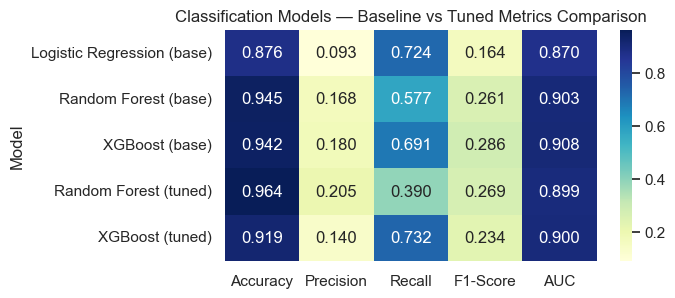

In [180]:
plt.figure(figsize=(6,3))
sns.heatmap(class_compare, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Classification Models — Baseline vs Tuned Metrics Comparison")
plt.show()


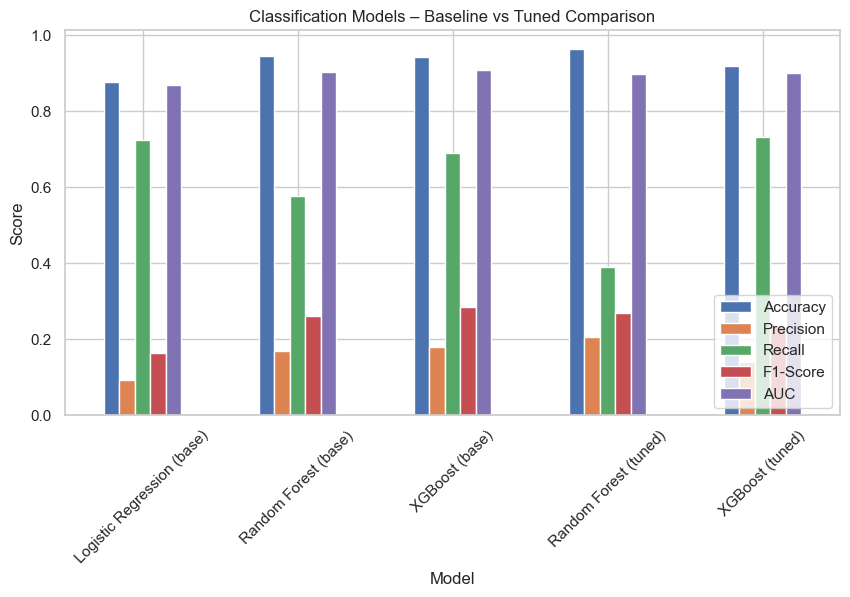

In [181]:
class_compare.plot(kind="bar", figsize=(10,5))
plt.title("Classification Models – Baseline vs Tuned Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.show()


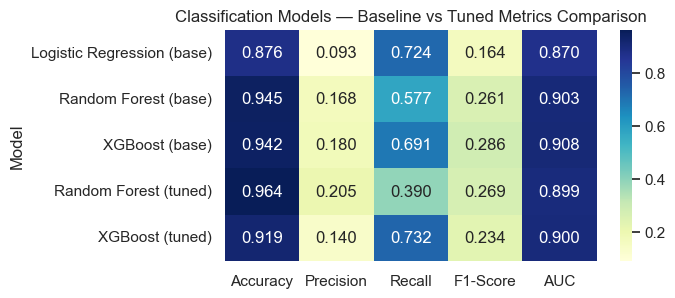

In [182]:
plt.figure(figsize=(6,3))
sns.heatmap(class_compare, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Classification Models — Baseline vs Tuned Metrics Comparison")
plt.show()


In [183]:
# Build combined regression comparison table
reg_compare = pd.DataFrame({
    "Model": [
        "Linear Regression (base)",
        "Random Forest (base)",
        "XGBoost (base)",
        "XGBoost (tuned)"
    ],
    "MSE": [
        mean_squared_error(y_test_r, y_pred_lin),
        mean_squared_error(y_test_r, y_pred_rf_r_base),
        mean_squared_error(y_test_r, y_pred_xgb_r_base),
        mean_squared_error(y_test_r, y_pred_xgb_r_tuned)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test_r, y_pred_lin)),
        np.sqrt(mean_squared_error(y_test_r, y_pred_rf_r_base)),
        np.sqrt(mean_squared_error(y_test_r, y_pred_xgb_r_base)),
        np.sqrt(mean_squared_error(y_test_r, y_pred_xgb_r_tuned))
    ],
    "MAE": [
        mean_absolute_error(y_test_r, y_pred_lin),
        mean_absolute_error(y_test_r, y_pred_rf_r_base),
        mean_absolute_error(y_test_r, y_pred_xgb_r_base),
        mean_absolute_error(y_test_r, y_pred_xgb_r_tuned)
    ],
    "R²": [
        r2_score(y_test_r, y_pred_lin),
        r2_score(y_test_r, y_pred_rf_r_base),
        r2_score(y_test_r, y_pred_xgb_r_base),
        r2_score(y_test_r, y_pred_xgb_r_tuned)
    ]
}).set_index("Model")

reg_compare


,MSE,RMSE,MAE,R²
Model,,,,
Linear Regression (base),0.06,0.24,0.07,0.82
Random Forest (base),0.05,0.23,0.05,0.83
XGBoost (base),0.05,0.23,0.06,0.84
XGBoost (tuned),0.05,0.23,0.06,0.84


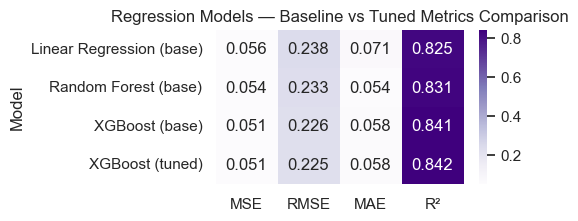

In [184]:
plt.figure(figsize=(4,2))
sns.heatmap(reg_compare, annot=True, cmap="Purples", fmt=".3f")
plt.title("Regression Models — Baseline vs Tuned Metrics Comparison")
plt.show()


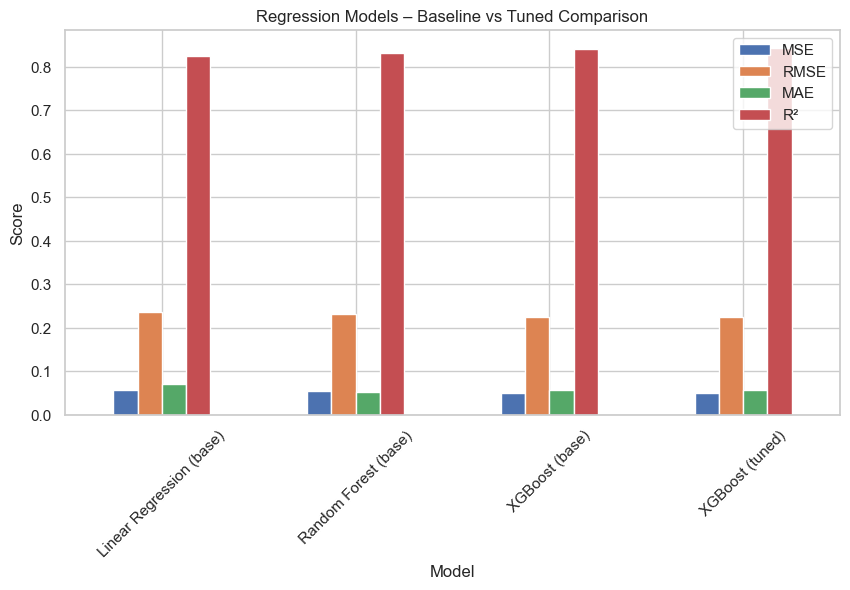

In [185]:
reg_compare.plot(kind="bar", figsize=(10,5))
plt.title("Regression Models – Baseline vs Tuned Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc="upper right")
plt.show()


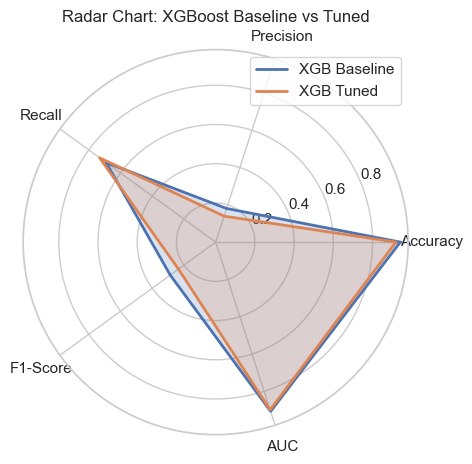

In [186]:
from math import pi

# Only compare baseline XGB vs tuned XGB
metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "AUC"]

baseline_vals = class_compare.loc["XGBoost (base)", metrics].values
tuned_vals = class_compare.loc["XGBoost (tuned)", metrics].values

angles = [n / float(len(metrics)) * 2 * pi for n in range(len(metrics))]
angles += angles[:1]  # close loop

baseline = np.concatenate((baseline_vals, [baseline_vals[0]]))
tuned = np.concatenate((tuned_vals, [tuned_vals[0]]))

plt.figure(figsize=(5,5))
ax = plt.subplot(111, polar=True)

plt.xticks(angles[:-1], metrics)

ax.plot(angles, baseline, linewidth=2, linestyle='solid', label="XGB Baseline")
ax.fill(angles, baseline, alpha=0.2)

ax.plot(angles, tuned, linewidth=2, linestyle='solid', label="XGB Tuned")
ax.fill(angles, tuned, alpha=0.2)

plt.title("Radar Chart: XGBoost Baseline vs Tuned")
plt.legend(loc="upper right")
plt.show()


11. Feature Importance (Tuned Models)

11.1 Classification – tuned XGBoost

In [187]:
importances_class = pd.Series(
    best_xgb_clf.feature_importances_,
    index=X_train_c.columns
).sort_values(ascending=False)

importances_class.head(20)


any_late                                            0.19
NAME_FAMILY_STATUS_Widow                            0.03
OCCUPATION_TYPE_Secretaries                         0.03
months_on_book                                      0.02
FLAG_OWN_CAR_Y                                      0.02
OCCUPATION_TYPE_Core staff                          0.02
NAME_INCOME_TYPE_State servant                      0.02
max_month                                           0.02
CODE_GENDER_M                                       0.02
FLAG_OWN_REALTY_Y                                   0.02
NAME_FAMILY_STATUS_Married                          0.02
FLAG_WORK_PHONE                                     0.02
NAME_INCOME_TYPE_Pensioner                          0.02
FLAG_EMAIL                                          0.02
NAME_HOUSING_TYPE_House / apartment                 0.02
NAME_EDUCATION_TYPE_Higher education                0.02
DAYS_BIRTH                                          0.02
NAME_INCOME_TYPE_Working       

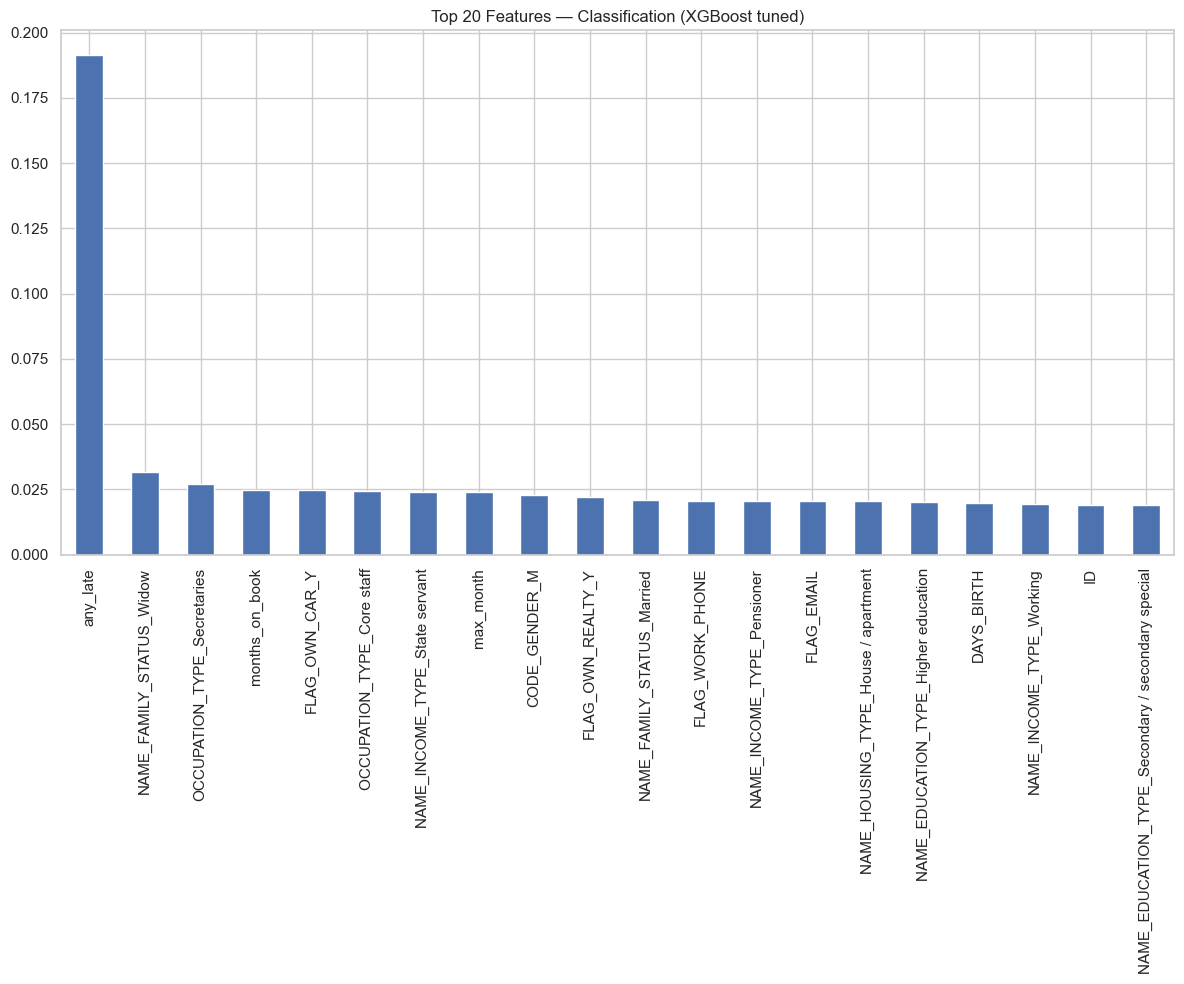

In [188]:
plt.figure(figsize=(12, 10))
importances_class.head(20).plot(kind="bar")
plt.title("Top 20 Features — Classification (XGBoost tuned)")
plt.tight_layout()
plt.show()


11.2 Regression – tuned XGBoost

In [189]:
importances_reg = pd.Series(
    best_xgb_reg.feature_importances_,
    index=X_train_r.columns
).sort_values(ascending=False)

importances_reg.head(20)


any_late                                            0.37
months_on_book                                      0.12
NAME_EDUCATION_TYPE_Secondary / secondary special   0.02
NAME_INCOME_TYPE_Pensioner                          0.02
CNT_CHILDREN                                        0.02
NAME_HOUSING_TYPE_House / apartment                 0.02
OCCUPATION_TYPE_Laborers                            0.02
NAME_FAMILY_STATUS_Married                          0.02
FLAG_WORK_PHONE                                     0.01
OCCUPATION_TYPE_Core staff                          0.01
CNT_FAM_MEMBERS                                     0.01
NAME_INCOME_TYPE_Working                            0.01
DAYS_EMPLOYED                                       0.01
CODE_GENDER_M                                       0.01
OCCUPATION_TYPE_Managers                            0.01
NAME_FAMILY_STATUS_Single / not married             0.01
OCCUPATION_TYPE_IT staff                            0.01
FLAG_OWN_CAR_Y                 

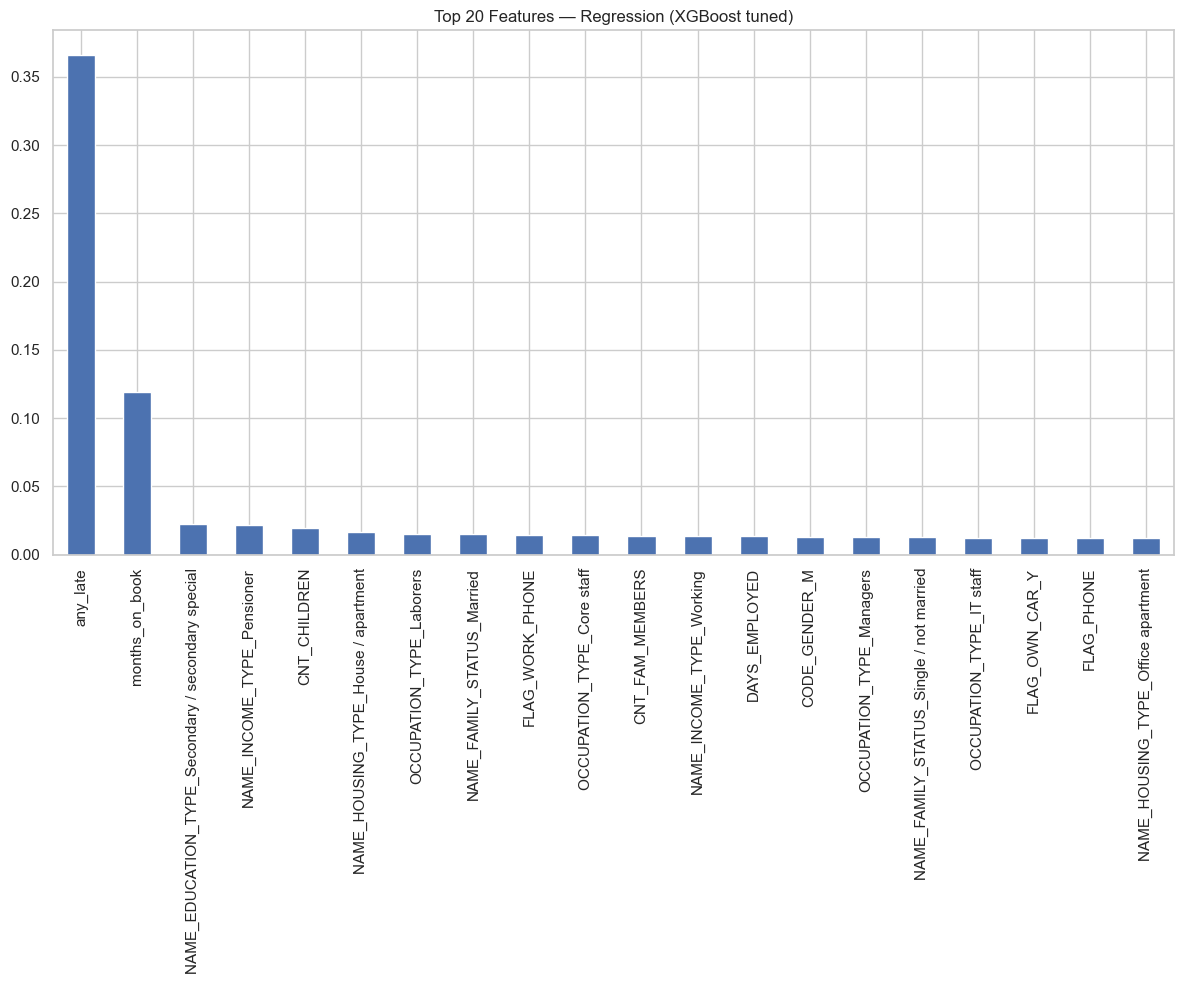

In [190]:
plt.figure(figsize=(12, 10))
importances_reg.head(20).plot(kind="bar")
plt.title("Top 20 Features — Regression (XGBoost tuned)")
plt.tight_layout()
plt.show()


12. Hybrid prediction function

In [196]:
def hybrid_predict_from_encoded(encoded_row: pd.DataFrame):
    """
    encoded_row: 1-row dataframe with same columns as X_train_c.
    Returns:
        - label (GOOD/BAD)
        - probability of BAD
        - predicted risk_score (regression)
    """
    # Ensure correct column order
    encoded_row = encoded_row.reindex(columns=X_train_c.columns, fill_value=0)
    
    # Classification
    prob_bad = best_xgb_clf.predict_proba(encoded_row)[0][1]
    label = "BAD" if prob_bad > 0.5 else "GOOD"
    
    # Regression
    risk_pred = best_xgb_reg.predict(encoded_row)[0]
    
    return label, prob_bad, risk_pred

# Example with first test record
sample_encoded = X_test_c.iloc[[0]]
hybrid_predict_from_encoded(sample_encoded)


('GOOD', 0.023079881, 0.1338696)